In [1]:
# import sys
# sys.path.append('./algorithms/')
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy
from typing import Any, Dict, List, Tuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class ActorCritic(nn.Module):

    def __init__(self, policy, encoder):
        super().__init__()
        self.policy = policy
        self.encoder = encoder
    
    def get_actor_params(self):
        return self.policy.get_actor_params()

    def get_critic_params(self):
        return self.policy.get_critic_params()

    def forward_actor(self, inputs):
        return self.policy.forward_actor(inputs)

    def forward_critic(self, inputs):
        return self.policy.forward_critic(inputs)
    
    def act(self, state, latent, belief=None, task=None, deterministic = False):
        return self.policy.act(state, latent, belief, task, deterministic)

    def get_value(self, state, latent, belief=None, task=None):
        value, _ = self.policy.forward(state, latent, belief, task)
        return value

    def evaluate_actions(self, state, latent, belief, task, action):
        """Call policy eval, set task, belief to None"""
        return self.policy.evaluate_actions(state, latent, belief, task, action)
    
        ## TODO: what to do about 'sample'? check what this arg is?
    # def forward(self, actions, states, rewards, hidden_state, return_prior=False, sample=True, detach_every=None):
    #     # really want this to take the inputs for the encoder and then output the outputs of the policy
    #     # we only want to get the prior when there are no previous rewards, actions or hidden states
    #     # should only occur at the very start of the continual learning process
    #     if hidden_state is None:
    #         # print('Hidden state is None!!:', hidden_state)
    #         _, latent_mean, latent_logvar, hidden_state = self.encoder.prior(states.shape[1]) # check that this gets the batch size?
    #     else:
    #         _, latent_mean, latent_logvar, hidden_state = self.encoder(actions, states, rewards, hidden_state, return_prior, sample, detach_every)
        
    #     latent_mean = F.relu(latent_mean)
    #     latent_logvar = F.relu(latent_logvar)
    #     latent = torch.cat((latent_mean, latent_logvar), dim=-1).reshape(1, -1)
    #     # none for belief and task
    #     return self.policy(states, latent, None, None), hidden_state, latent
    
    # def prior(self, num_processes):
    #     return self.encoder.prior(num_processes)
        

In [3]:
# get RL2 trained policy for example
RUN_FOLDER = './logs/logs_ML10-v2/rl2_73__25:10_21:13:08'
policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
encoder_net = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [4]:
#1. get prior at start for base latent
# (does this reset the hidden state? I think so)
#2. feed policy observation + latent -> gets action, obs, reward, done
#3. feed encoder action, obs, reward, done and hidden state to get next action
import metaworld
import random

ml10 = metaworld.ML10() # Construct the benchmark, sampling tasks

training_envs = []
training_names = []
for name, env_cls in ml10.test_classes.items():
  env = env_cls()
  task = random.choice([task for task in ml10.test_tasks
                        if task.env_name == name])
  env.set_task(task)
  env.name = name
  training_envs.append(env)
  ## set names

  # training_names.append(name)

In [5]:
from algorithms.custom_storage import CustomOnlineStorage
from algorithms.custom_ppo import CustomPPO
from utils.custom_logger import CustomLogger
from environments.custom_env_utils import prepare_parallel_envs

# num_processes = 4
# combined network with encoder + policy
ac = ActorCritic(policy_net, encoder_net)
agent = CustomPPO(
    actor_critic=ac,
    value_loss_coef = 0.4,
    entropy_coef = 0.001,
    policy_optimiser='adam',
    policy_anneal_lr=False,
    train_steps = 2,
    lr = 1.0e-5,
    eps=1.0e-8,
    clip_param = 0.2,
    ppo_epoch = 3,
    use_huber_loss = True,
    use_clipped_value_loss=True,
    context_window=None
)

# logger = CustomLogger('test_logs', 'dummy')
# env = training_envs[0]
# env = ContinualEnv(training_envs, 500)
# envs = SubprocVecEnv([make_continual_env('continualMW-v0', **{'envs' : training_envs}) for i in range(num_processes)])


In [6]:
from environments.custom_env_utils import prepare_parallel_envs
from continuallearner import ContinualLearner
num_processes = 4
steps_per_env = 2000
rollout_len = 500
## effective steps_per_env = num_processes * steps_per_env = 8000

## TODO: make an env creation function?
# envs = SubprocVecEnv([make_continual_env('continualMW-v0', **{'envs' : training_envs, 'steps_per_env': steps_per_env}) for i in range(num_processes)])
# env = PyTorchVecEnvCont(envs, device)
envs = prepare_parallel_envs(training_envs, steps_per_env, num_processes, device)

continual_learner = ContinualLearner(
    42,
    training_envs, 
    agent, 
    num_processes, 
    rollout_len,
    steps_per_env,
    # logger,
    'test_logs',
    'dummy',
    log_every = 5
)

Seeding random, torch, numpy.
Note that due to parallel processing results will be similar but not identical. Use only one process and set --deterministic_execution to True if you want identical results (only recommended for debugging).


2023-12-12 20:50:37.981262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 20:50:38.080494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-12 20:50:38.080513: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-12 20:50:38.533981: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

logging under test_logs/dummy__12:12_20:50:37


In [7]:
continual_learner.train()

Evaluating at Episode: 4
eval completed in 23.572580575942993


KeyboardInterrupt: 

In [10]:
k = torch.load('test_logs/dummy__12:12_20:50:37/actor_critic.pt')

In [11]:
import csv
training_task = 'task1'
tasks = ['task1', 'task2']
quantiles = [0.05,0.5, 0.95]
reward_dict = {'task1': torch.tensor([1.,2.,3.,4.,5.]), 'task2': torch.tensor([1.,5.,6.,9.,3.])}
success_dict = {'task1': 0.5, 'task2': 0.1}

to_write = []

with open('dummy.csv', 'a') as f:
    writer = csv.writer(f, delimiter=',')
    for task in tasks:
        reward_quantiles = torch.quantile(reward_dict[task], torch.tensor(quantiles)).numpy().tolist()
        successes = success_dict[task]
        to_write = [task, *reward_quantiles, successes]
        
        writer.writerow(to_write)

# task_reward_quantiles=[(k, *list(zip(['q_' + str(q) for q in quantiles])torch.quantile(v, torch.tensor(quantiles)).numpy().tolist()) for k, v in reward_dict.items()]




# list(zip(['q_' + str(q) for q in quantiles], task_reward_quantiles))
# task_reward_quantiles

In [12]:
writer = csv.writer('dummy.csv', delimiter=',')
writer.writerow(to_write)

ValueError: I/O operation on closed file.

In [54]:
import pandas as pd
# import seaborn as sns
# new_res = {k:(*res[k][0:5], res[k][-1].cpu().detach().numpy() / 500) for k in res.keys()}
df = pd.DataFrame(res)
df.index = ['value_loss', 'actor_loss', 'entropy_loss', 'total_loss', 'task', 'episode_reward']
df = df.T.reset_index().melt(id_vars = ['task', 'index'])
df.loc[:,'value'] = df.loc[:, 'value'].astype(float)

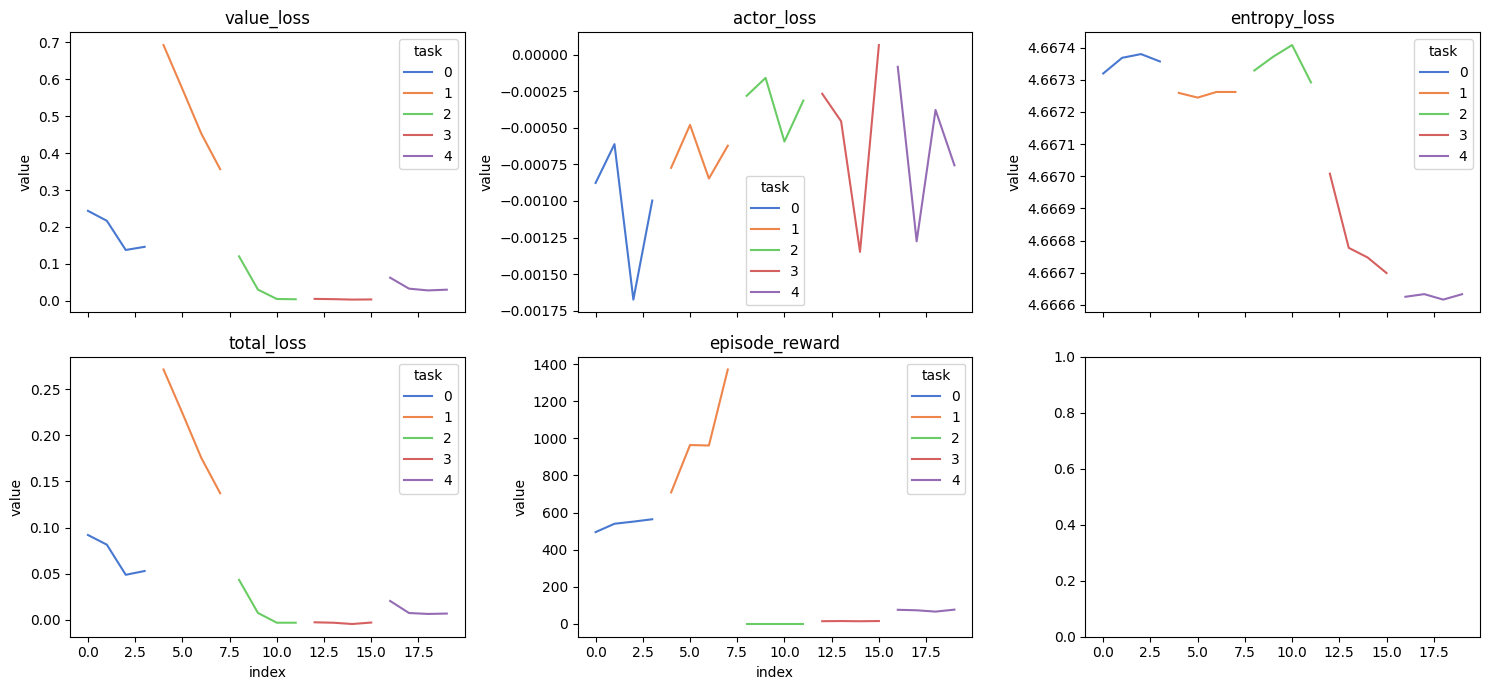

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,3, figsize = (15, 7), sharex = True)
ax = ax.flatten()
for i, col in enumerate(['value_loss', 'actor_loss', 'entropy_loss', 'total_loss', 'episode_reward']):

    sns.lineplot(
        data = df.query(f"variable=='{col}'"),
        x = 'index',
        y = 'value',
        hue = 'task',
        palette = 'muted',
        ax = ax[i]
        # style='task'
        )
    ax[i].set_title(f'{col}')

plt.tight_layout()
plt.show()

In [7]:
num_processes = 4
steps_per_env = 4000
rollout_len = 1000

print(
    steps_per_env % num_processes * rollout_len == 0,
    steps_per_env - num_processes * rollout_len >= 0
    )

True True


In [12]:
envs = prepare_parallel_envs(training_envs, steps_per_env, num_processes, device)
obs = envs.reset()
with torch.no_grad():
    _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_processes)

    ## TODO: set the 500 to some sort of variable (max episode len?)
    # assert len(storage.latent) == 0  # make sure we emptied buffers
    # print(f"saving hidden state to {i * 500}")

    latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)#.reshape(1, -1)



value, action = agent.act(obs, latent, None, None)
next_obs, reward, done, info = envs.step(action)

value, action = agent.act(obs, latent, None, None)
next_obs, reward2, done, info2 = envs.step(action)

In [13]:
successes = []
successes.append(torch.tensor([i['success'] for i in info]))
successes.append(torch.tensor([i['success'] for i in info2]))

In [22]:
torch.stack(successes).max(0)[0].sum() / num_processes

tensor(0.)

: 

In [37]:
rews = torch.stack([reward.squeeze(), reward2.squeeze()], 0)

In [57]:
rews[1]

tensor([1.2067, 1.2100], device='cuda:0')

In [85]:
qtiles = [0.1, 0.5, 0.9]
q = torch.tensor(qtiles).to(device)
dict(zip(qtiles, torch.quantile(rews, q)))
# torch.quantile(rews, q)

{0.1: tensor(1.2077, device='cuda:0'),
 0.5: tensor(1.2112, device='cuda:0'),
 0.9: tensor(1.2126, device='cuda:0')}

In [68]:
for i in torch.quantile(rews,torch.tensor([0.1, 0.5, 0.9]).to(device), dim = 1).mean(1):
    print(i)

tensor(1.2097, device='cuda:0')
tensor(1.2105, device='cuda:0')
tensor(1.2112, device='cuda:0')


In [ ]:
## Run continual world environments in training loop rather than in raw env
## 1. Select initial env and create vectorised environments
## 2. Run for N steps (where N is param)
## 3. When N is reached, switch env, create vectorised environments
## 4. continue until no more envs

## alternative 1:
## set steps_per_env* = steps_per_env / (num_processes x rollout_len)
## would run same number of steps, but paralellised

## alternative 2: 
## set num_processes to 1
## may not be sufficient to learn

In [41]:
num_processes = 4
steps_per_env = 2000
rollout_len = 500
## effective steps_per_env = num_processes * steps_per_env = 8000
envs = SubprocVecEnv([make_continual_env('continualMW-v0', **{'envs' : training_envs, 'steps_per_env': steps_per_env}) for i in range(num_processes)])
env = PyTorchVecEnvCont(envs, device)
storage = CustomOnlineStorage(
    rollout_len, num_processes, env.observation_space.shape[0]+1, 0, 0,
    env.action_space, ac.encoder.hidden_size, ac.encoder.latent_dim, False)
res = dict()
eps = 0
while env.get_env_attr('cur_step') < env.get_env_attr('steps_limit'):
    print(f"current step: {env.get_env_attr('cur_step')}; limit: {env.get_env_attr('steps_limit')}")
    step = 0

    
    # if I do this, I need to make sure my returns are calculated correctly / the done flags work
    # for i in range(num_episodes_per_update):
    obs = env.reset()
    current_task = env.get_env_attr("cur_seq_idx")
    episode_reward = 0
    done = [False for _ in range(num_processes)]
    # print(f"running episode {i}")
    ## get prior??? how frequent?
    # do at start of each episode for now
    with torch.no_grad():
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_processes)
        print(step)
        ## TODO: set the 500 to some sort of variable (max episode len?)
        assert len(storage.latent) == 0  # make sure we emptied buffers
        # print(f"saving hidden state to {i * 500}")
        storage.hidden_states[:1].copy_(hidden_state)
        latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)#.reshape(1, -1)
        storage.latent.append(latent)

    while not all(done):
        value, action = agent.act(obs, latent, None, None)
        next_obs, reward, done, info = env.step(action)
        assert all(done) == any(done), "Metaworld envs should all end simultaneously"

        obs = next_obs
        episode_reward += reward.sum() / num_processes

        ## TODO: do I even need masks?
        # create mask for episode ends
        masks_done = torch.FloatTensor([[0.0] if _done else [1.0] for _done in done]).to(device)
        # bad_mask is true if episode ended because time limit was reached
        # don't care for metaworld
        bad_masks = torch.FloatTensor([[0.0] for _done in done]).to(device)

        # if done:
        #     print(f'{step}: done!')
        #     hidden_state = agent.actor_critic.encoder.reset_hidden(hidden_state, masks_done)
        # print(action.size(), obs.squeeze(0).size(), reward.squeeze(0).size(), hidden_state.size(), latent.size(), masks_done.size(), bad_masks.size())
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
        latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]#.reshape(1, -1)

        
        storage.next_state[step] = obs.clone()
        # print(action.squeeze(0).size(), obs.squeeze(0).size(), reward.squeeze(0).size(), hidden_state.size(), latent.size(), masks_done.size(), bad_masks.size())
        storage.insert(
            state=obs.squeeze(),
            belief=None,
            task=None,
            actions=action.double(),
            rewards_raw=reward.squeeze(0),
            rewards_normalised=reward.squeeze(0),#rew_normalised, don't use
            value_preds=value.squeeze(0),
            masks=masks_done.squeeze(0), # do I even need these?
            bad_masks=bad_masks.squeeze(0), 
            done=torch.from_numpy(done)[:,None].float(),
            hidden_states = hidden_state.squeeze(),
            latent = latent#.unsqueeze(1),
        )

        step += 1
        ### update
        # if step % num_updates ==0:

    # update at the end of each episode?
    res[eps] = (*agent.update(storage), current_task, episode_reward.cpu().detach().numpy())

    # # # should clear out old data
    storage.after_update()
    # update total steps
    # env.__setattr__('cur_step',  num_processes * rollout_len)
    eps+=1
    
        




current step: 0; limit: 10000
0
current step: 500; limit: 10000
0
current step: 1000; limit: 10000
0
current step: 1500; limit: 10000
0
current step: 2000; limit: 10000
0
current step: 2500; limit: 10000
0
current step: 3000; limit: 10000
0
current step: 3500; limit: 10000
0
current step: 4000; limit: 10000
0
current step: 4500; limit: 10000
0
current step: 5000; limit: 10000
0
current step: 5500; limit: 10000
0
current step: 6000; limit: 10000
0
current step: 6500; limit: 10000
0
current step: 7000; limit: 10000
0
current step: 7500; limit: 10000
0
current step: 8000; limit: 10000
0
current step: 8500; limit: 10000
0
current step: 9000; limit: 10000
0
current step: 9500; limit: 10000
0


In [50]:
import pandas as pd
# import seaborn as sns
new_res = {k:(*res[k][0:5], res[k][-1].cpu().detach().numpy() / 500) for k in res.keys()}
df = pd.DataFrame(new_res)
df.index = ['value_loss', 'actor_loss', 'entropy_loss', 'total_loss', 'task', 'episode_reward']
df.T.reset_index().melt(id_vars = ['task', 'index'])
# df.T.plot()

,task,index,variable,value
0,0.0,0,value_loss,0.237375
1,0.0,1,value_loss,0.238127
2,0.0,2,value_loss,0.270180
3,0.0,3,value_loss,0.173969
4,1.0,4,value_loss,0.746167
...,...,...,...,...
95,3.0,15,episode_reward,0.021147
96,4.0,16,episode_reward,0.135644
97,4.0,17,episode_reward,0.117424
98,4.0,18,episode_reward,0.146787


<Axes: xlabel='index', ylabel='value'>

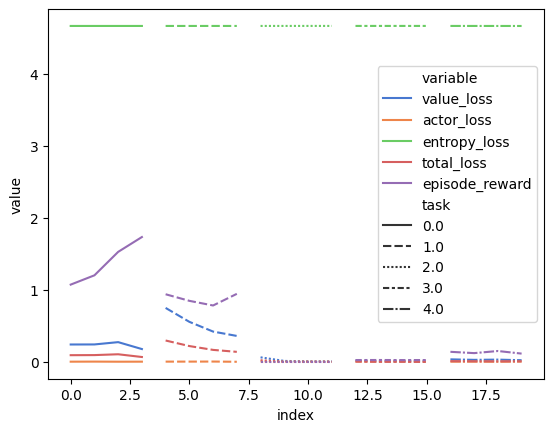

In [54]:
import seaborn as sns

sns.lineplot(
    data = df.T.reset_index().melt(id_vars = ['task', 'index']),
    x = 'index',
    y = 'value',
    hue = 'variable',
    palette = 'muted',
    style='task'


)

In [29]:
values, log_probs, action_values = agent.actor_critic.evaluate_actions(
    storage.prev_state[:-1],
    torch.stack(storage.latent[:-1]),#torch.cat(storage.latent[:-1]),
    None,
    None,
    storage.actions
)

In [26]:
torch.stack(storage.latent[:-1]).size()

torch.Size([500, 1, 4, 256])

In [28]:
torch.cat(storage.latent[:-1]).size()

torch.Size([500, 4, 256])

In [31]:
log_probs.min()

tensor(-185.0985, device='cuda:0', grad_fn=<MinBackward1>)

In [17]:
print(
    torch.cat(storage.latent[:-1]).size(),
    storage.prev_state[:-1].size(),
    storage.actions.size()
)

torch.Size([500, 4, 256]) torch.Size([500, 4, 40]) torch.Size([500, 4, 4])


In [12]:
storage.actions

tensor([[[ 0.3123, -0.8121,  0.7445,  1.1550],
         [ 1.8017,  0.5680,  0.8695, -0.4735],
         [ 1.4292,  1.8534, -1.0493,  1.1551],
         [-0.4722, -0.7281,  0.4747,  0.6222]],

        [[ 0.6972,  0.4875, -0.3274,  1.7530],
         [ 0.2888,  0.4767,  0.5483,  0.1638],
         [ 1.5668,  1.2545, -0.5558,  0.1735],
         [ 2.8981,  0.4671,  0.6913, -0.2662]],

        [[ 1.5318,  0.9153,  0.5392,  2.5992],
         [ 0.7968,  1.8277, -1.0111, -0.1006],
         [ 1.0232,  1.3677,  0.6708,  0.7862],
         [ 1.1805,  0.6021, -0.8926, -0.9356]],

        ...,

        [[-8.6578,  0.1204, -1.5586, -3.0550],
         [-6.8673, -1.9840, -1.3414, -2.6791],
         [-6.9235, -0.4342, -2.6258, -2.8675],
         [-7.2971, -0.7323, -1.4768, -3.6448]],

        [[-6.4243, -0.5177, -2.2652, -3.3827],
         [-7.2827, -1.2557, -0.5568, -3.5874],
         [-6.5266, -1.6540, -2.1240, -2.7305],
         [-7.6278, -0.2197, -1.0824, -3.0855]],

        [[-6.6662, -0.2482, -2.5053,

In [9]:
# -- get action values --
advantages = storage.returns[:-1] - storage.value_preds[:-1]
advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)

# recompute embeddings (to build computation graph)
agent._recompute_embeddings(storage, sample=False, update_idx=0,
                    detach_every= agent.context_window if agent.context_window is not None else None)

# update the normalisation parameters of policy inputs before updating
# don't think I need this
# self.actor_critic.update_rms(args=self.args, policy_storage=policy_storage)

# call this to make sure that the action_log_probs are computed
# (needs to be done right here because of some caching thing when normalising actions)
storage.before_update(agent.actor_critic)

value_loss_epoch = 0
action_loss_epoch = 0
dist_entropy_epoch = 0
loss_epoch = 0
for e in range(agent.ppo_epoch):

    data_generator = storage.feed_forward_generator(advantages, 20)
    for sample in data_generator:

        state_batch, actions_batch, latent_batch, value_preds_batch, \
        return_batch, old_action_log_probs_batch, adv_targ = sample
        break
        # if not rlloss_through_encoder:
        # state_batch = state_batch.detach()
        ## TODO: I think I should not detach this
        latent_batch = latent_batch#.detach()

        # Reshape to do in a single forward pass for all steps
        values, action_log_probs, dist_entropy = \
            agent.actor_critic.evaluate_actions(state=state_batch, latent=latent_batch,
                                                belief=None, task=None,
                                                action=actions_batch)
        # break
        ratio = torch.exp(action_log_probs.double() -
                            old_action_log_probs_batch.double())
        # break

        surr1 = ratio * adv_targ
        surr2 = torch.clamp(ratio, 1.0 - agent.clip_param, 1.0 + agent.clip_param) * adv_targ
        action_loss = -torch.min(surr1, surr2).mean()

        if agent.use_huber_loss and agent.use_clipped_value_loss:
            value_pred_clipped = value_preds_batch + (values - value_preds_batch).clamp(-agent.clip_param,
                                                                                        agent.clip_param)
            value_losses = F.smooth_l1_loss(values, return_batch, reduction='none')
            value_losses_clipped = F.smooth_l1_loss(value_pred_clipped, return_batch, reduction='none')
            value_loss = 0.5 * torch.max(value_losses, value_losses_clipped).mean()
        elif agent.use_huber_loss:
            value_loss = F.smooth_l1_loss(values, return_batch)
        elif agent.use_clipped_value_loss:
            value_pred_clipped = value_preds_batch + (values - value_preds_batch).clamp(-agent.clip_param,
                                                                                        agent.clip_param)
            value_losses = (values - return_batch).pow(2)
            value_losses_clipped = (value_pred_clipped - return_batch).pow(2)
            value_loss = 0.5 * torch.max(value_losses, value_losses_clipped).mean()
        else:
            value_loss = 0.5 * (return_batch - values).pow(2).mean()

        # zero out the gradients
        agent.optimiser.zero_grad()

        # compute policy loss and backprop
        loss = value_loss * agent.value_loss_coef + action_loss - dist_entropy * agent.entropy_coef

        # compute vae loss and backprop
        # if rlloss_through_encoder:
        #     loss += self.args.vae_loss_coeff * compute_vae_loss()

        # compute gradients (will attach to all networks involved in this computation)
        loss.backward()

        # clip gradients
        nn.utils.clip_grad_norm_(agent.actor_critic.parameters(), agent.max_grad_norm)
        # nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.args.policy_max_grad_norm)

        # in oursetup loss is always through encoder
        # if rlloss_through_encoder:
        #     if self.args.encoder_max_grad_norm is not None:
        #         nn.utils.clip_grad_norm_(encoder.parameters(), self.args.encoder_max_grad_norm)



        value_loss_epoch += value_loss.item()
        action_loss_epoch += action_loss.item()
        dist_entropy_epoch += dist_entropy.item()
        loss_epoch += loss.item()
        print(value_loss, action_loss, dist_entropy, loss_epoch)

        # if rlloss_through_encoder:
        # recompute embeddings (to build computation graph) during updates
        agent._recompute_embeddings(storage, sample=False, update_idx=e + 1,
                                        detach_every= agent.context_window if agent.context_window is not None else None)
        # utl.recompute_embeddings(policy_storage, encoder, sample=False, update_idx=e + 1,
        #                              detach_every= self.context_window if self.context_window is not None else None)



# num_updates = agent.ppo_epoch * agent.num_mini_batch

# value_loss_epoch /= num_updates
# action_loss_epoch /= num_updates
# dist_entropy_epoch /= num_updates
# loss_epoch /= num_updates

# print(value_loss_epoch, action_loss_epoch, dist_entropy_epoch, loss_epoch)


In [10]:
storage.action_log_probs

tensor([[[-5.1854],
         [-4.4164],
         [-4.4030],
         [-4.5090]],

        [[-4.4312],
         [-3.3822],
         [-6.0335],
         [-5.9839]],

        [[-4.7691],
         [-4.0127],
         [-3.6651],
         [-3.7823]],

        ...,

        [[-4.2119],
         [-4.2209],
         [-4.1228],
         [-4.8274]],

        [[-6.6564],
         [-5.0212],
         [-3.8304],
         [-5.3056]],

        [[-3.8214],
         [-4.3288],
         [-4.3263],
         [-3.3277]]], device='cuda:0')

In [11]:
old_action_log_probs_batch #action_log_probs

tensor([[ -5.1908],
        [ -3.5976],
        [ -5.4055],
        [ -6.2718],
        [ -4.2716],
        [ -4.6790],
        [ -3.6692],
        [ -4.5106],
        [ -3.8674],
        [ -4.1244],
        [ -5.4279],
        [ -3.8490],
        [ -5.4406],
        [ -4.5643],
        [ -7.5824],
        [ -3.2127],
        [ -3.5732],
        [ -3.7019],
        [ -3.1522],
        [ -5.0758],
        [ -3.6826],
        [ -4.6915],
        [ -3.3817],
        [-10.2276],
        [ -3.4740],
        [ -5.1020],
        [ -3.7318],
        [ -5.4021],
        [ -6.7121],
        [ -5.1902],
        [ -5.2535],
        [ -7.0028],
        [ -5.0640],
        [ -4.0627],
        [ -2.9140],
        [ -4.1290],
        [ -4.5848],
        [ -3.5823],
        [ -3.7406],
        [ -4.8732],
        [ -5.6764],
        [ -4.0928],
        [ -7.2210],
        [ -5.7211],
        [ -3.5553],
        [ -5.6675],
        [ -3.2729],
        [ -8.3437],
        [ -3.5655],
        [ -4.0110],


In [28]:
print(action_log_probs[1], old_action_log_probs_batch[1], torch.exp(action_log_probs[1].double()-old_action_log_probs_batch[1].double()))

tensor([nan], device='cuda:0', grad_fn=<SelectBackward>) tensor([nan], device='cuda:0') tensor([nan], device='cuda:0', dtype=torch.float64, grad_fn=<ExpBackward>)


In [50]:
torch.exp(action_log_probs.double()-old_action_log_probs_batch.double())

tensor([[2.3499e+32],
        [1.6528e+30],
        [5.1500e+24],
        [8.3923e+31],
        [1.3204e+37],
        [3.8692e+14],
        [3.4331e+00],
        [1.1165e+35],
        [2.1644e+28],
        [2.0399e+34],
        [3.3670e+16],
        [6.8058e+32],
        [4.5027e+27],
        [1.5816e+37],
        [1.3747e+34],
        [1.6915e+42],
        [3.7975e+31],
        [2.8370e+37],
        [2.9846e+26],
        [8.2372e+36],
        [1.0000e+00],
        [2.5020e+30],
        [1.9451e+26],
        [8.4889e+30],
        [7.6723e+29],
        [4.5660e+32],
        [4.8400e+05],
        [3.0735e+33],
        [4.8087e+30],
        [8.4137e+25],
        [6.6569e+33],
        [1.5967e+30],
        [2.1457e+26],
        [7.2418e+32],
        [1.3342e+40],
        [4.1398e+28],
        [3.4154e+23],
        [8.5343e+27],
        [2.2317e+25],
        [1.1792e+29],
        [2.2029e+00],
        [3.4505e+33],
        [1.2725e+29],
        [9.8799e+29],
        [1.6061e+28],
        [7